In [ ]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import tensorflow.keras.metrics
from tensorflow.keras.utils import to_categorical
import tensorflow_hub as hub
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
pd.options.display.max_columns
pd.options.display.max_rows
from tensorflow.keras.utils import to_categorical
pd.options.display.max_rows

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


60

In [ ]:
!git clone https://github.com/Jmazo25/Monografia.git

Cloning into 'Monografia'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), done.


In [ ]:
df = pd.read_csv("/content/Monografia/train.csv")

#Búsqueda de nulos

Previamente ya se detectató una fila con valores nulos por lo cual se procede a eliminar

In [ ]:
df.dropna(axis = 0, how ='any',inplace=True)
df.reset_index(inplace=True)
df.shape

(27480, 5)

In [ ]:
df.head(3)

,index,textID,text,selected_text,sentiment
0,0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,2,088c60f138,my boss is bullying me...,bullying me,negative


#Eiliminación de stop words

In [ ]:
def clean_text(t):
  tl = []
  t = t.lower().split()
  for i in t:
    if i not in stopwords.words('english'):
      tl.append(i)
  return " ".join(tl)

In [ ]:
#Limpiar expresiones Regulares
df['text'] = df['text'].apply((lambda x:re.sub('@[^\s]+','',x)))
df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
df['text'] = df['text'].apply((lambda x: re.sub("'","",x)))
df['text'] = df['text'].apply((lambda x: re.sub("`","",x)))
#Remover stopwords
df['text'] = df['text'].apply(lambda x: clean_text(x))

In [ ]:
##Limpiar expresiones Regulares
df['selected_text'] = df['selected_text'].apply((lambda x:re.sub('@[^\s]+','',x)))
df['selected_text'] = df['selected_text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
df['selected_text'] = df['selected_text'].apply((lambda x: re.sub("'","",x)))
df['selected_text'] = df['selected_text'].apply((lambda x: re.sub("`","",x)))
#Remover StopWords
df['selected_text'] = df['selected_text'].apply(lambda x: clean_text(x))

In [ ]:
df.head(5)

,index,textID,text,selected_text,sentiment
0,0,cb774db0d1,id responded going,id responded going,neutral
1,1,549e992a42,sooo sad miss san diego,sooo sad,negative
2,2,088c60f138,boss bullying,bullying,negative
3,3,9642c003ef,interview leave alone,leave alone,negative
4,4,358bd9e861,sons couldnt put releases already bought,sons,negative


#Máxima longitud de un tweet en el dataset

Se procede a buscar el tweet con mayor longitud en términos de palabras

In [ ]:
dim_tw = df['text'].str.split().str.len()

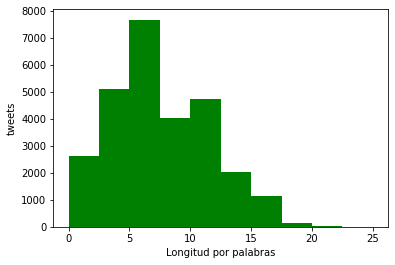

In [ ]:
fig, ax1 = plt.subplots()
plt.hist(dim_tw,color='green')
ax1.set_xlabel('Longitud por palabras'), ax1.set_ylabel("tweets")
plt.show()

In [ ]:
dim_tw.describe()

count    27480.000000
mean         7.363392
std          3.960305
min          0.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         25.000000
Name: text, dtype: float64

#BERT

In [ ]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)

In [ ]:
!pip install bert-for-tf2

     |████████████████████████████████| 41 kB 131 kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30534 sha256=e4e03e3972ec13ebb92339da5bcde9e6d5ad87cb07fa9b4e35b66bb623a6945d
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19473 sha256=e6eef77a101c8ae9f22e03d0cab625181a79330d004228a11135e3c7c04fa425
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7912 sha256=48e2830a0dcc81cc6eeef6d16846bc90054837847910865819ce9c20dfc1e6fe
  Stored in directory: /root/.cache/pip/wheels/e1/11/67/33cc51bbee127cb8fb2ba549cd29109b2f22da43ddf9969716
Successfully built bert-for-tf2 params-flow py-params


In [ ]:
import bert
FullTokenizer = bert.bert_tokenization.FullTokenizer

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [ ]:
all_sentences = df['text'].values
all_words = []
maximo = 0
for j, sent in enumerate(all_sentences):
    temp = []
    temp.append('[CLS]')
    i = 0
    for w in tokenizer.tokenize(sent):
        i+=1
        temp.append(w)
    temp.append('[SEP]')
    all_words.append(temp)
    if i> maximo:
        maximo = i
maximo

58

In [ ]:
len(all_words[11559])

60

In [ ]:
max_seq_length = maximo + 2  # Your choice here.

In [ ]:
def get_masks(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))


def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))


def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [ ]:
s = "This is a nice's"
stokens = tokenizer.tokenize(s)
stokens = ["[CLS]"] + stokens + ["[SEP]"]

input_ids1 = get_ids(stokens, tokenizer, max_seq_length)
input_masks1 = get_masks(stokens, max_seq_length)
input_segments1 = get_segments(stokens, max_seq_length)

In [ ]:
print(stokens)
print(input_ids1)
print(input_masks1)
print(input_segments1)

['[CLS]', 'this', 'is', 'a', 'nice', "'", 's', '[SEP]']
[101, 2023, 2003, 1037, 3835, 1005, 1055, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
len(input_ids1)

60

##Transformar el texto tokenizado en las 3 entradas necesarias en el modelo

In [ ]:
input_ids = np.zeros((len(all_words),max_seq_length))
input_masks = np.zeros((len(all_words),max_seq_length))
input_segments = np.zeros((len(all_words),max_seq_length))
for i in range(len(all_words)):
    input_ids[i,:] = np.array(get_ids(all_words[i], tokenizer, max_seq_length)).reshape(1,-1)
    input_masks[i,:] = np.array(get_masks(all_words[i], max_seq_length)).reshape(1,-1)
    input_segments[i,:] = np.array(get_segments(all_words[i], max_seq_length)).reshape(1,-1)

In [ ]:
input_ids.shape

(27480, 60)

Funciones que permiten extraer los índices inicial y final del texto seleccionado del tweet

In [ ]:
def ind(t1,t2):
    l = []
    ini = int
    fin = int
    t1 = t1.lower().split()
    t2 = t2.lower().split()
    for i in t2:
        for ind,j in enumerate(t1):
          if i == j:
            l.append(ind)
    if l != []:
        ini=(l[0])
        fin=(l[-1])
    else:
        ini = 0
        fin = 0
    return ini

In [ ]:
def ind2(t1,t2):
  l = []
  ini = int
  fin = int
  t1 = t1.lower().split()
  t2 = t2.lower().split()
  for i in t2:
    for ind,j in enumerate(t1):
      if i == j:
        l.append(ind)
  if l != []:
    ini=(l[0])
    fin=(ini+len(t2)-1)
  else:
    ini = 0
    fin = 0
  return fin

test funciones

In [ ]:
f= ind2('no. lost link sent pull battery.','sent pull')
f

4

Creación de dataset donde se manipularán los datos

In [ ]:
df2 = df[['text','selected_text']] 

Aplicación de las funciones de consecución de índices

In [ ]:
y_true_i = df2.apply(lambda x: ind(x['text'],x['selected_text']),axis=1)

In [ ]:
y_true_f = df2.apply(lambda x: ind2(x['text'],x['selected_text']),axis=1)

Validación de índices negativos

In [ ]:
a = [(y_true_i[p],y_true_f[p]) for p in range(y_true_i.shape[0]) if y_true_i[p] > y_true_f[p]]
a

[]

Agregar dos variables al dataset con índice inicial y final

In [ ]:
df2['start_w'] = y_true_i
df2['end_w'] = y_true_f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


validación de tipo de datos en cada las dos variables previamente generadas

In [ ]:
val_shape_f = [(type(y_true_f)) for i in range(y_true_f.shape[0]) if type(y_true_f[i]) != type(y_true_f[0]) ]
val_shape_i = [(type(y_true_i)) for i in range(y_true_i.shape[0]) if type(y_true_i[i]) != type(y_true_i[0]) ]
val_shape_f, val_shape_i

([], [])

#Longitud de cada tweet

Se almacena en una variable la longitud de cada tweet esto para remover el padding al calcular las métricas luego de realizar una predicción al conjunto de test

In [ ]:
def leng2(x):
  return len(x.lower().split())

In [ ]:
def leng(x):
  x = x.lower().split()
  a = len(x)
  return a

In [ ]:
a = 'hola mi nombre es Gufy y soy el mejor perro del mundo'
b = leng2(a)
c = leng(a)
print(b,c)

12 12


In [ ]:
long = df2.apply(lambda x: leng(x['text']),axis=1)
long = np.array(long)

In [ ]:
df2.head()

,text,selected_text,start_w,end_w
0,id responded going,id responded going,0,2
1,sooo sad miss san diego,sooo sad,0,1
2,boss bullying,bullying,1,1
3,interview leave alone,leave alone,1,2
4,sons couldnt put releases already bought,sons,0,0


#One-hot encodding

In [ ]:
y_true_i = to_categorical(y_true_i)

In [ ]:
y_true_i

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_true_f = to_categorical(y_true_f)

In [ ]:
y_true_i.shape, y_true_f.shape

((27480, 22), (27480, 25))

#nuevo padding

In [ ]:
def pad(a,ml):
  if len(a) == 0:
    c = np.zeros(ml)
  else:
    b = np.pad(a,ml-len(a))
    c = b[ml-len(a):]
    c = np.array(c,dtype='float32')
  #return list(c)
  return c

In [ ]:
y_true_i_2 = [pad(i,25) for i in y_true_i]
y_true_i=np.array(y_true_i_2,dtype='float32')

In [ ]:
y_true_f_2 = [pad(i,25) for i in y_true_f]
y_true_f=np.array(y_true_f_2,dtype='float32')

In [ ]:
y_true_f.shape, y_true_i.shape

((27480, 25), (27480, 25))

In [ ]:
y_true_i[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

#Codificación del sentimiento para ser una entrada válida en el modelo


In [ ]:
labels1 = {"sentiment": {"neutral":0,"positive":1,"negative":2}}

In [ ]:
df = df.replace(labels1)
labels = df['sentiment']
#labels
#labels = to_categorical(labels)

In [ ]:
labels

0        0
1        2
2        2
3        2
4        2
        ..
27475    2
27476    2
27477    1
27478    1
27479    0
Name: sentiment, Length: 27480, dtype: int64

In [ ]:
labels.shape

(27480,)

#Split de la data

In [ ]:
Input_ids_tr, input_ids_te, Input_masks_tr, input_masks_te, Input_segments_tr, input_segments_te,Y_train_i,y_test_i,Y_train_f,y_test_f,long_train,long_test, TS_train, ts_test,l_train,l_test = train_test_split(input_ids, input_masks, input_segments,y_true_i,y_true_f,long,df['text'],labels, test_size=0.15, random_state=42)
input_ids_tr, input_ids_val,input_masks_tr, input_masks_val,input_segments_tr, input_segments_val,y_train_i,y_val_i,y_train_f,y_val_f,l_train,l_val= train_test_split(Input_ids_tr,Input_masks_tr,Input_segments_tr,Y_train_i,Y_train_f,long_train, test_size=0.1, random_state=42)


In [ ]:
input_ids_tr.shape, input_ids_val.shape,input_masks_tr.shape, input_masks_val.shape,input_segments_tr.shape, input_segments_val.shape

((21022, 60), (2336, 60), (21022, 60), (2336, 60), (21022, 60), (2336, 60))

In [ ]:
y_train_i.shape,y_val_i.shape,y_train_f.shape,y_val_f.shape

((21022, 25), (2336, 25), (21022, 25), (2336, 25))

In [ ]:
ts_test.shape

(4122,)

#Definición de métricas

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#Diseño de 3 modelos

In [ ]:
tf.config.list_physical_devices('GPU')
tf.distribute.MirroredStrategy

tensorflow.python.distribute.mirrored_strategy.MirroredStrategy

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv1D, MaxPooling1D, LSTM, Concatenate, RepeatVector, Concatenate, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model,Input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Bidirectional
from keras.layers import Flatten
from keras.layers import Embedding
from tensorflow.keras import callbacks
from numpy import array
from numpy import asarray
from numpy import zeros
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import Recall, Precision

##Modelo con una red neuronal recurrente LSTM

In [ ]:
input_word_ids = Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

sentiment = Input(shape=(1,), dtype='int32')

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

xs = Embedding(3,20)(sentiment)
xs = Flatten()(xs)
xs = RepeatVector(60)(xs)

x = Concatenate(axis=-1)([xs,sequence_output])

#recurrent = Bidirectional(LSTM(50,return_sequences=True))(x)
recurrent2 = LSTM(50,return_sequences=False)(x)
        
dense1 = Dense(128,activation='relu')(recurrent2)
drop1 = Dropout(0.3)(dense1)
        
dense21 = Dense(25,activation='softmax')(drop1)
dense22 = Dense(25,activation='softmax')(drop1)
early = EarlyStopping(monitor='loss', patience=2,restore_best_weights=True)

model2 = Model(inputs=[input_word_ids, input_mask, segment_ids,sentiment], outputs=[dense21,dense22])
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model2.compile(loss=['categorical_crossentropy','categorical_crossentropy'], optimizer=optimizer,metrics=['accuracy',Recall(),Precision()])
model2.summary()

#model2.fit([input_ids_tr,input_masks_tr,input_segments_tr,l_train], [y_train_i,y_train_f], validation_split=0.1,batch_size=32, epochs=4, verbose=1,callbacks=[early])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 20)        60          input_1[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 20)           0           embedding[0][0]                  
__________________________________________________________________________________________________
input_word_ids (InputLayer)     [(None, 60)]         0                                            
______________________________________________________________________________________________

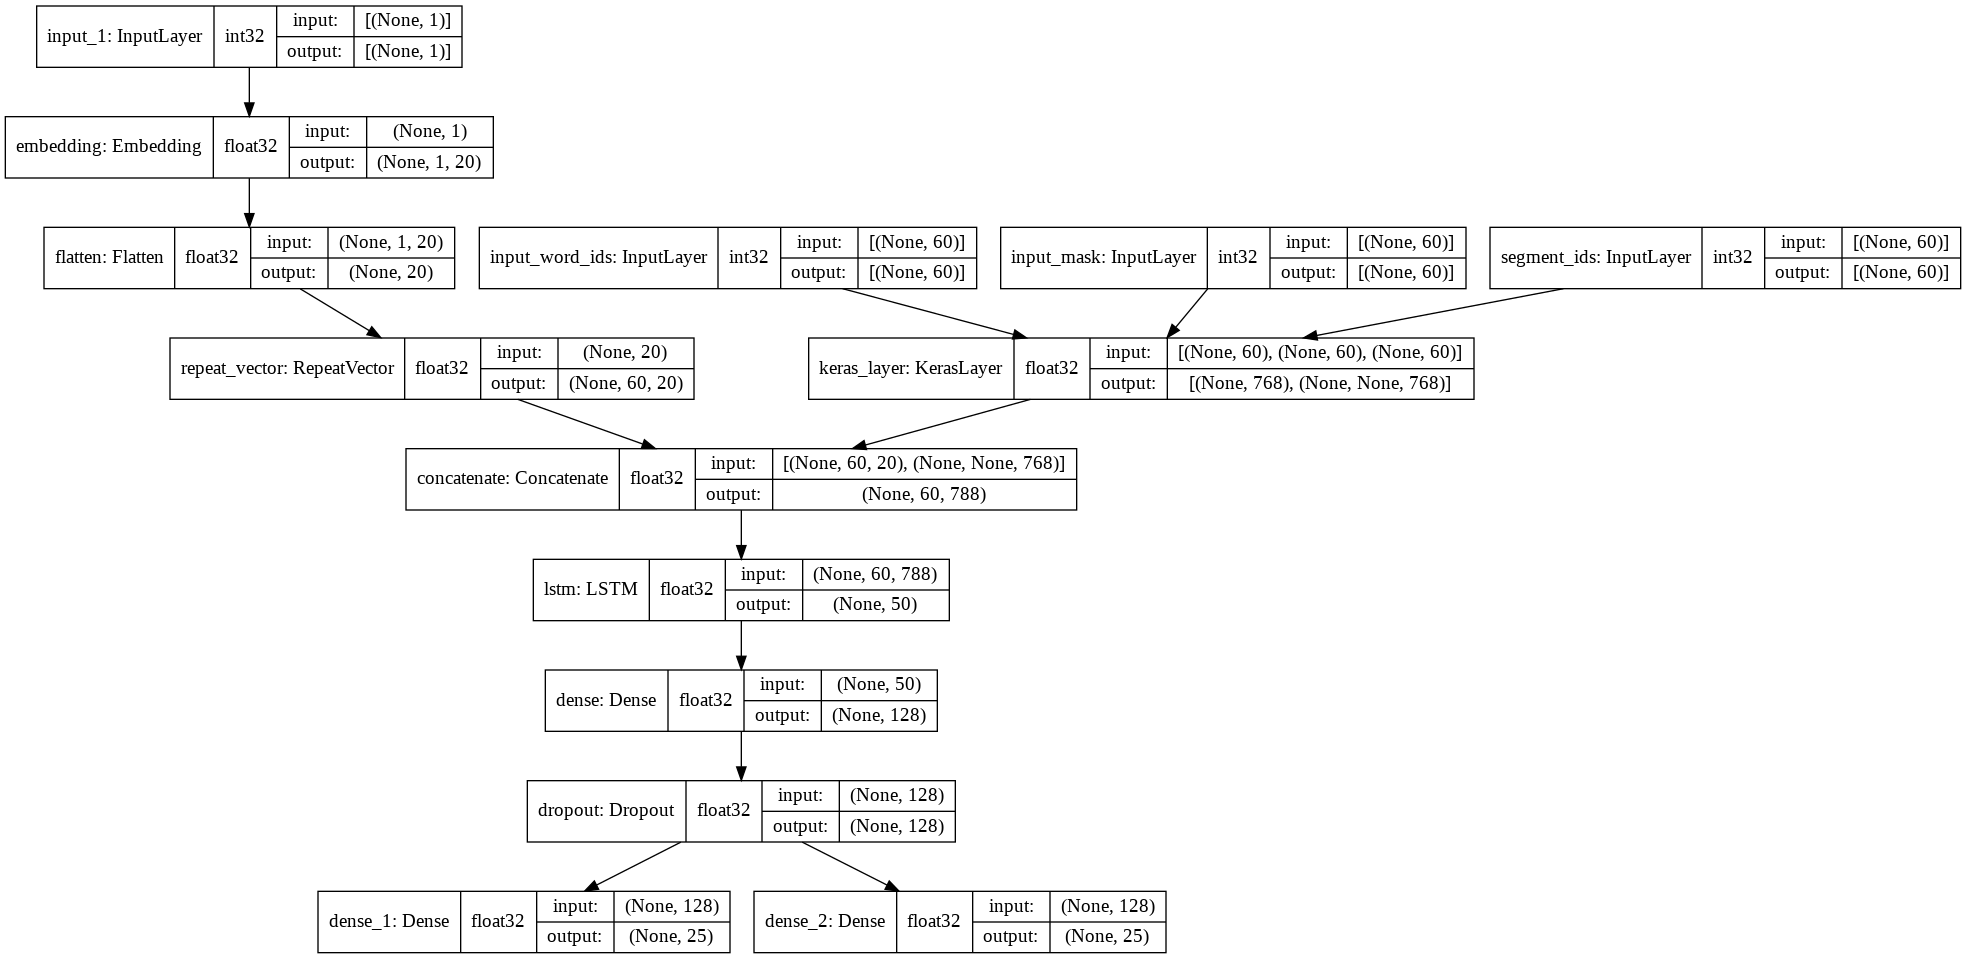

In [ ]:
tensorflow.keras.utils.plot_model(model2, "BERT.png",show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96,
    layer_range=None)

In [ ]:
model2.fit([input_ids_tr,input_masks_tr,input_segments_tr,l_train], [y_train_i,y_train_f], validation_split=0.1,batch_size=32, epochs=12, verbose=1,callbacks=[early])

Epoch 1/12
592/592 [==============================] - 194s 316ms/step - loss: 5.1166 - dense_19_loss: 2.0988 - dense_20_loss: 3.0178 - dense_19_accuracy: 0.5718 - dense_19_recall_6: 0.2030 - dense_19_precision_6: 0.6486 - dense_20_accuracy: 0.0821 - dense_20_recall_6: 0.0000e+00 - dense_20_precision_6: 0.0000e+00 - val_loss: 4.3908 - val_dense_19_loss: 1.6504 - val_dense_20_loss: 2.7404 - val_dense_19_accuracy: 0.6205 - val_dense_19_recall_6: 0.5892 - val_dense_19_precision_6: 0.6245 - val_dense_20_accuracy: 0.1317 - val_dense_20_recall_6: 0.0000e+00 - val_dense_20_precision_6: 0.0000e+00
Epoch 2/12
592/592 [==============================] - 185s 312ms/step - loss: 4.3233 - dense_19_loss: 1.6233 - dense_20_loss: 2.7000 - dense_19_accuracy: 0.6290 - dense_19_recall_6: 0.4888 - dense_19_precision_6: 0.6473 - dense_20_accuracy: 0.1302 - dense_20_recall_6: 5.2857e-05 - dense_20_precision_6: 0.2500 - val_loss: 4.0999 - val_dense_19_loss: 1.5504 - val_dense_20_loss: 2.5496 - val_dense_19_acc

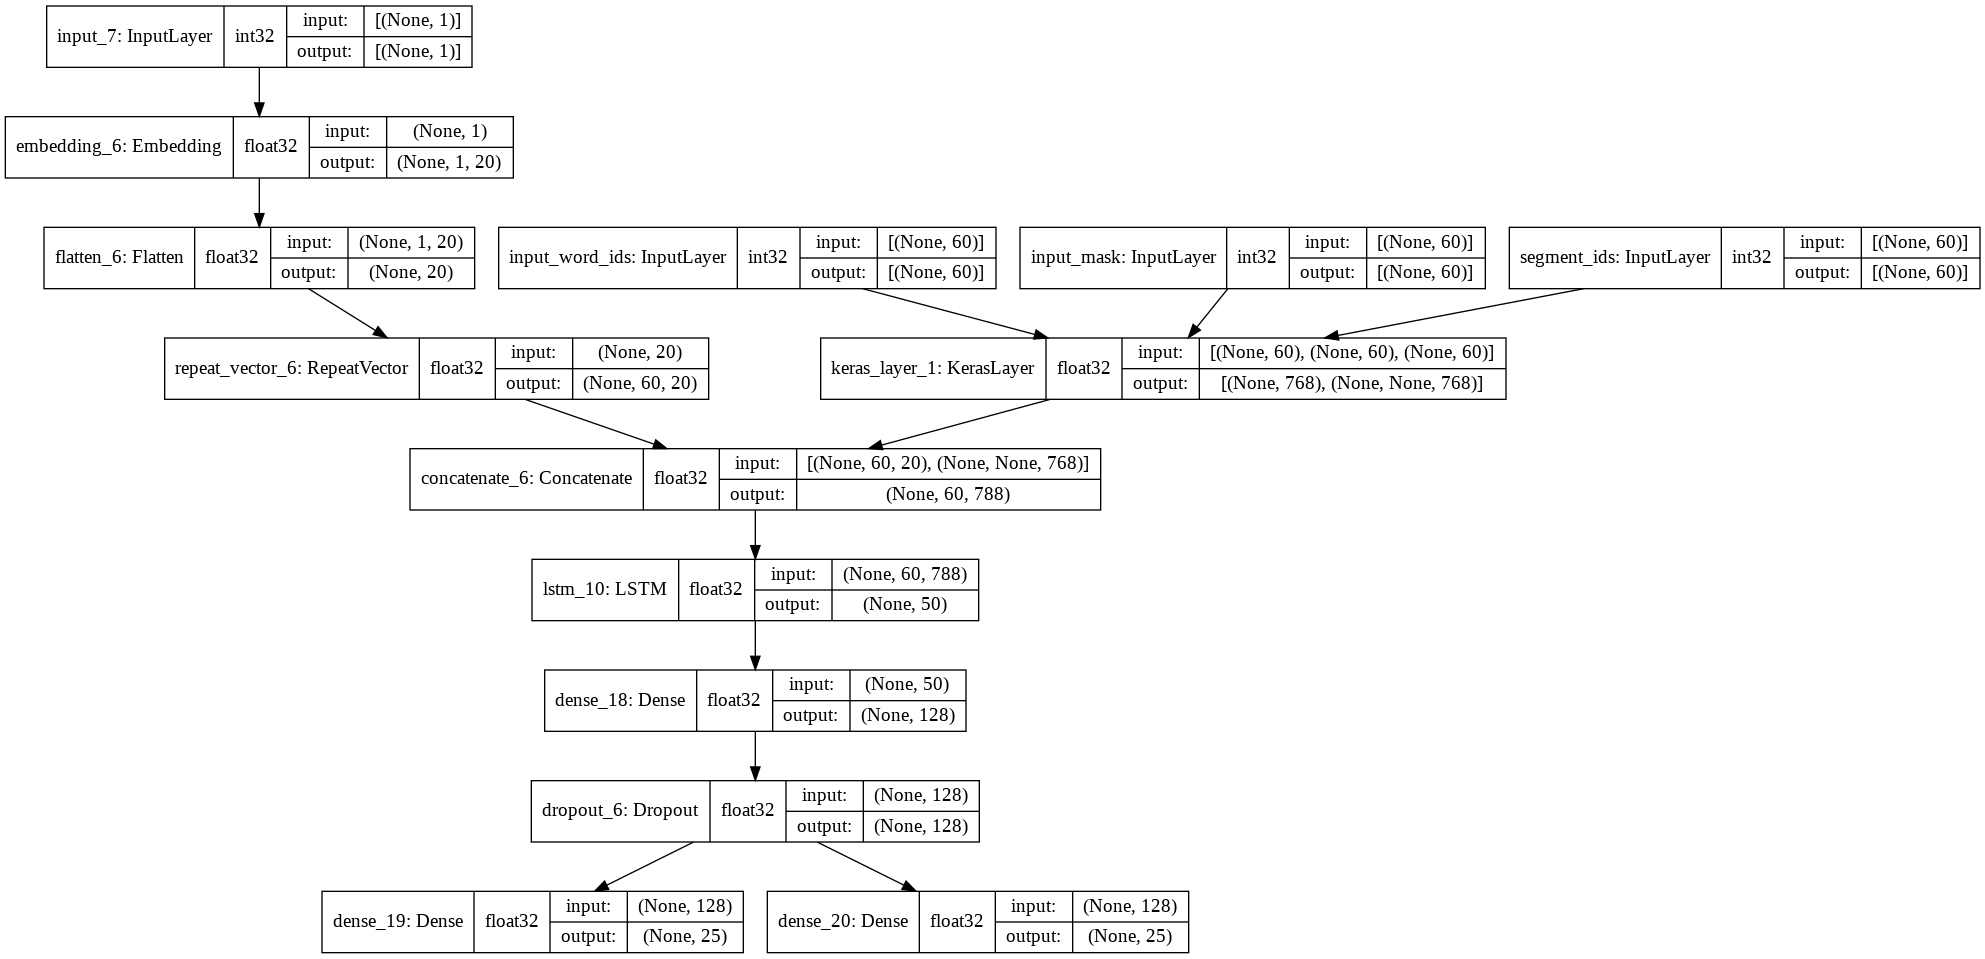

In [ ]:
tensorflow.keras.utils.plot_model(model2, "bert_model.png",show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96,
    layer_range=None)

#Modelo basado en redes neuronales Convolucionales

In [ ]:
input_word_ids = Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

sentiment = Input(shape=(1,), dtype='int32')

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

xs = Embedding(3,20)(sentiment)
xs = Flatten()(xs)
xs = RepeatVector(60)(xs)

x = Concatenate(axis=-1)([xs,sequence_output])


x = Conv1D(256, 5, activation='relu',padding = 'same')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(256, 5, activation='relu')(x)
x = MaxPooling1D(21)(x)
x1 = tf.keras.layers.Flatten()(x)
x1 = Dense(256, activation='relu')(x1)

x11 = Dense(25, activation='softmax')(x1)
    

x2 = Dense(25, activation='softmax')(x1)

early = EarlyStopping(monitor='loss', patience=2,restore_best_weights=True)

model = Model(inputs=[input_word_ids, input_mask, segment_ids,sentiment], outputs=[x11,x2])
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.compile(loss=['categorical_crossentropy','categorical_crossentropy'], optimizer=optimizer,metrics=['accuracy',Recall(),Precision()])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 20)        60          input_5[0][0]                    
__________________________________________________________________________________________________
flatten_9 (Flatten)             (None, 20)           0           embedding_4[0][0]                
__________________________________________________________________________________________________
input_word_ids (InputLayer)     [(None, 60)]         0                                            
____________________________________________________________________________________________

In [ ]:
model.fit([input_ids_tr,input_masks_tr,input_segments_tr,l_train], [y_train_i,y_train_f], validation_split=0.1,batch_size=32, epochs=12, verbose=1,callbacks=[early])

##Modelo RNN sin anexarle el sentimiento

In [ ]:
input_word_ids = Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

#sentiment = Input(shape=(1,), dtype='int32')

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#xs = Embedding(3,20)(sentiment)
#xs = Flatten()(xs)
#xs = RepeatVector(60)(xs)

#x = Concatenate(axis=-1)([xs,sequence_output])

#recurrent = Bidirectional(LSTM(50,return_sequences=True))(x)
recurrent2 = LSTM(50,return_sequences=False)(sequence_output)
        
dense1 = Dense(128,activation='relu')(recurrent2)
drop1 = Dropout(0.3)(dense1)
        
dense21 = Dense(25,activation='softmax')(drop1)
dense22 = Dense(25,activation='softmax')(drop1)
early = EarlyStopping(monitor='loss', patience=2,restore_best_weights=True)

model3 = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[dense21,dense22])
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model3.compile(loss=['categorical_crossentropy','categorical_crossentropy'], optimizer=optimizer,metrics=['accuracy',Recall(),Precision()])
model3.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 60)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 60)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [ ]:
model3.fit([input_ids_tr,input_masks_tr,input_segments_tr], [y_train_i,y_train_f], validation_split=0.1,batch_size=32, epochs=12, verbose=1,callbacks=[early])

Epoch 1/12
592/592 [==============================] - 189s 320ms/step - loss: 3.9930 - dense_21_loss: 1.5209 - dense_22_loss: 2.4721 - dense_21_accuracy: 0.6285 - dense_21_recall_5: 0.4705 - dense_21_precision_5: 0.6667 - dense_22_accuracy: 0.1462 - dense_22_recall_5: 0.0064 - dense_22_precision_5: 0.4859 - val_loss: 3.8442 - val_dense_21_loss: 1.4852 - val_dense_22_loss: 2.3590 - val_dense_21_accuracy: 0.6205 - val_dense_21_recall_5: 0.4826 - val_dense_21_precision_5: 0.6700 - val_dense_22_accuracy: 0.1612 - val_dense_22_recall_5: 0.0000e+00 - val_dense_22_precision_5: 0.0000e+00
Epoch 2/12
592/592 [==============================] - 189s 319ms/step - loss: 3.9044 - dense_21_loss: 1.4977 - dense_22_loss: 2.4067 - dense_21_accuracy: 0.6278 - dense_21_recall_5: 0.4675 - dense_21_precision_5: 0.6760 - dense_22_accuracy: 0.1552 - dense_22_recall_5: 0.0088 - dense_22_precision_5: 0.4548 - val_loss: 3.7649 - val_dense_21_loss: 1.4645 - val_dense_22_loss: 2.3003 - val_dense_21_accuracy: 0.620

#Pedicción

Nota: Recuerde cambiar el modelo

In [ ]:
predi_,predf_ = model3.predict([[input_ids_te,input_masks_te,input_segments_te,l_test]])

In [ ]:
predi_,predf_ = model3.predict([[input_ids_te,input_masks_te,input_segments_te]])

#Decodificación

In [ ]:
inicio,fin = [],[]
for i in range(predi_.shape[0]):
  k = np.argmax(predf_[i])
  j = np.argmax(predi_[i])
  inicio.append(j)
  fin.append(k) 


In [ ]:
for h in range(len(inicio)):
  if inicio[h] != 0:
    print(inicio[h])
  

In [ ]:
fin

In [ ]:
def dec(x):
  l = []
  for i in x:
    vec = np.zeros(29)
    ind = np.append(vec[:i],1)
    pad = np.zeros(29-i)
    r = np.concatenate((ind,pad),axis=0)
    l.append(r.astype('float32'))
  return np.array(l)

In [ ]:
pred_ini = dec(inicio)
pred_fin = dec(fin)

In [ ]:
pred_ini[76 ],pred_ini[76 ]
inic1 = np.where(pred_ini[76 ]==1)[0][0]
finc1 = np.where(pred_fin[76 ]==1)[0][0]
print(finc1,inic1,fin[76 ],inicio[76 ])
print(pred_fin[76 ],pred_ini[76 ])

2 1 2 1
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


In [ ]:
y_test_f[0].shape[0]

25

Validación Negativos

In [ ]:
  for c in range(pred_ini.shape[0]):
    inic = np.where(pred_ini[c]==1)[0][0]
    finc = np.where(pred_fin[c]==1)[0][0]
    #a = np.ones(fin-inic)
    if (finc - inic) < 0:
      print(c,(finc-inic))

#Pading

In [ ]:
def fill(x,y):
  l = []
  for c in range(x.shape[0]):
    inic = np.where(x[c]==1)[0][0]
    fin = np.where(y[c]==1)[0][0]
    if inic > fin:
      inic = 0
    uno = np.append(np.zeros(29)[:inic],1)
    dos = np.concatenate((uno,np.ones((fin-inic))))
    r = np.concatenate((dos,(np.zeros(29-dos.shape[0]))))
    #res = np.concatenate((uno,tres),axis=0)
    #r = np.concatenate((res,tres),axis=0)
    l.append(r)
  return np.array(l)

In [ ]:
y_test = fill(y_test_i,y_test_f)

In [ ]:
y_pred = fill(pred_ini,pred_fin)

In [ ]:
y_pred

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [ ]:
type(y_pred[9])

numpy.ndarray

#Métricas construídas

In [ ]:
print('recall:{}'.format(recall_m(y_test,y_pred)))
print('precision:{}'.format(precision_m(y_test,y_pred)))
print('F1:{}'.format(f1_m(y_test,y_pred)))

recall:0.7879687232418927
precision:0.5682182985530385
F1:0.6602897786566959


In [ ]:
a

'hola mi nombre es Gufy y soy el mejor perro del mundo'

##Accuracy

In [ ]:
p = 0
for n in range(y_test.shape[0]):
  for l in range(y_test[n].shape[0]):
    if y_test[n][l] == y_pred[n][l]:
      p = p + 1
print(p / (y_test.shape[0]*y_test.shape[1]),p)

0.8811591293145276 105332


##Precision

In [ ]:
fp = 0
tp = 0
for n in range(y_test.shape[0]):
  for l in range(y_test[n].shape[0]):
    #if y_test[n][l] == 1:
      #tp = tp + 1
    if y_test[n][l] == y_pred[n][l] and y_pred[n][l] == 1:
      tp = tp + 1
    if y_test[n][l] != y_pred[n][l] and y_pred[n][l] == 1:
      fp = fp + 1 


print(tp/(tp+fp))

0.5682182985553772


##Recall

In [ ]:
fn = 0
tp = 0
for n in range(y_test.shape[0]):
  for l in range(y_test[n].shape[0]):
    if y_test[n][l] == y_pred[n][l] and y_pred[n][l] == 1:
      tp = tp + 1
    if y_test[n][l] != y_pred[n][l] and y_pred[n][l] == 0:
      fn = fn + 1 


print(tp/(tp+fn))

0.5347868272358883


##Removiendo padding

In [ ]:
def withoutpadding(x,y):
  f = []
  for k,i in enumerate(x):
    a = i[:y[k]]
    f.append(a)
  return np.array(f)

In [ ]:
y_test_t = withoutpadding(y_test,long_test)
y_pred_p = withoutpadding(y_pred,long_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


Métricas

##Presicion sin padding

In [ ]:
fp = 0
tp = 0
for n in range(y_test_t.shape[0]):
  for l in range(y_test_t[n].shape[0]):
    #if y_test[n][l] == 1:
      #tp = tp + 1
    if y_test_t[n][l] == y_pred_p[n][l] and y_pred_p[n][l] == 1:
      tp = tp + 1
    if y_test_t[n][l] != y_pred_p[n][l] and y_pred_p[n][l] == 1:
      fp = fp + 1 


print(tp/(tp+fp))

0.5831008538337983


##Precisión con Padding

In [ ]:
fp = 0
tp = 0
for n in range(y_test.shape[0]):
  for l in range(y_test[n].shape[0]):
    #if y_test[n][l] == 1:
      #tp = tp + 1
    if y_test[n][l] == y_pred[n][l] and y_pred[n][l] == 1:
      tp = tp + 1
    if y_test[n][l] != y_pred[n][l] and y_pred[n][l] == 1:
      fp = fp + 1 


print(tp/(tp+fp))

0.5682182985553772


##Accuracy sin padding

In [ ]:
p = 0
count = 0
for n in range(y_test_t.shape[0]):
  for l in range(y_test_t[n].shape[0]):
    count = count + 1
    if y_test_t[n][l] == y_pred_p[n][l]:
      p = p + 1
print(p / count)

0.5569073783359497


##Recall sin padding

In [ ]:
fn = 0
tp = 0
for n in range(y_test_t.shape[0]):
  for l in range(y_test_t[n].shape[0]):
    if y_test_t[n][l] == y_pred_p[n][l] and y_pred_p[n][l] == 1:
      tp = tp + 1
    if y_test_t[n][l] != y_pred_p[n][l] and y_pred_p[n][l] == 0:
      fn = fn + 1 


print(tp/(tp+fn))

0.789187643020595


##Jaccard

In [ ]:
text_true = list(ts_test)

In [ ]:
text_true

Función dec jaccard

In [ ]:
def decjac(a,b):
  op=[]
  for i,j in enumerate(a):
    if j == 1:
      op.append(b.split()[i])
  return " ".join(op)

In [ ]:
j_test=[]
for ki in range(len(text_true)):
  j_test.append(decjac(y_test_t[ki],text_true[ki]))

In [ ]:
j_pred=[]
for kp in range(len(text_true)):
  j_pred.append(decjac(y_pred_p[kp],text_true[kp]))

In [ ]:
j_pred


In [ ]:
def jaccard(str1, str2):
    if len(str1) == 0 and len(str2) == 0:
      return 0.0
    else:
      a = set(str1.lower().split()) 
      b = set(str2.lower().split())
      c = a.intersection(b)
      return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
rest2 = [jaccard(j_test[i],j_pred[i]) for i in range(len(j_test))]

In [ ]:
print("el promedio de jaccard es: {}".format(round((sum(rest2)/len(rest2)),3)))

el promedio de jaccard es: 0.549
